In [1]:
import numpy as np
import sncosmo
from astropy.table import Table
from matplotlib import pyplot as plt

import sys; sys.path.insert(0, '../')
from data_access import sdss


## Check filter transmission curves

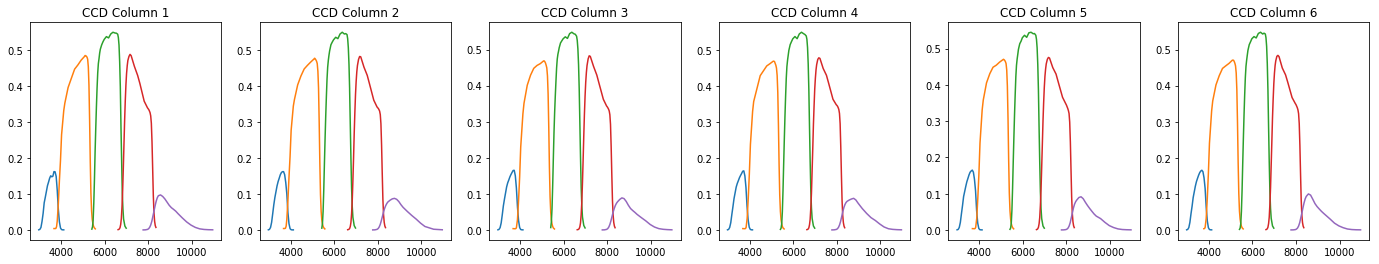

In [2]:
fig, axes = plt.subplots(1, 6, figsize=(24, 4))
for i, axis in enumerate(axes):
    for band in 'ugriz':
        band = sncosmo.get_bandpass('doi_2010_{}{}'.format(band, i + 1))
        axis.plot(band.wave, band.trans)
        axis.set_title('CCD Column {}'.format(i + 1))


## Get outlier data points

In [3]:
f_path = '/Users/daniel/Github/SDSS-Classification/data_access/sdss/data/SDSS_dataRelease-snana/SDSS_allCandidates+BOSS/SDSS_allCandidates+BOSS.IGNORE'

outliers = dict()
with open(f_path) as ofile:
    for line in ofile.readlines():
        if line.startswith('IGNORE:'):
            line_list = line.split()
            cid, mjd, band = line_list[1], line_list[2], line_list[3]
            if cid not in outliers:
                outliers[cid] = dict(u=[], g=[], r=[], i=[], z=[])
            
            outliers[cid][band].append(mjd)

outliers

{'1032': {'g': ['53668.387'],
  'i': ['53668.387'],
  'r': ['53668.387'],
  'u': [],
  'z': []},
 '11306': {'g': [], 'i': ['53670.418'], 'r': [], 'u': [], 'z': []},
 '12855': {'g': [], 'i': ['54048.1562'], 'r': [], 'u': [], 'z': []},
 '12907': {'g': [], 'i': [], 'r': [], 'u': ['54025.383'], 'z': []},
 '12979': {'g': ['54047.3164', '54008.304'],
  'i': ['54024.3789'],
  'r': ['54024.3789', '54047.3164'],
  'u': [],
  'z': []},
 '13072': {'g': ['53996.242'], 'i': [], 'r': [], 'u': [], 'z': []},
 '13180': {'g': [], 'i': [], 'r': ['54024.332'], 'u': [], 'z': []},
 '13323': {'g': ['54041.1406'], 'i': [], 'r': [], 'u': [], 'z': []},
 '13327': {'g': ['54054.203',
   '54036.188',
   '54052.184',
   '54055.180',
   '54058.180'],
  'i': [],
  'r': [],
  'u': [],
  'z': []},
 '13376': {'g': [], 'i': [], 'r': [], 'u': [], 'z': ['54006.3086']},
 '13495': {'g': [], 'i': [], 'r': ['54053.4141'], 'u': [], 'z': []},
 '13518': {'g': ['54021.379'],
  'i': ['54021.379'],
  'r': ['54021.379'],
  'u': [],
 

## Get SDSS published table of spectroscopically confirmed SNIa

In [4]:
spec_confirmed_sn = sdss.master_table[sdss.master_table['Classification'] == 'zSNIa']
spec_confirmed_sn.show_in_notebook(display_length=10)


idx,CID,RA,DEC,Nsearchepoch,IAUName,Classification,Peakrmag,MJDatPeakrmag,NepochSNR5,nSNspec,nGALspec,zspecHelio,zspecerrHelio,zCMB,zerrCMB,x0SALT2zspec,x0errSALT2zspec,x1SALT2zspec,x1errSALT2zspec,cSALT2zspec,cerrSALT2zspec,PeakMJDSALT2zspec,PeakMJDderrSALT2zspec,muSALT2zspec,muerrSALT2zspec,fitprobSALT2zspec,chi2SALT2zspec,ndofSALT2zspec,deltaMLCS2k2zspec,deltaerrMLCS2k2zspec,avMLCS2k2zspec,averrMLCS2k2zspec,PeakMJDMLCS2k2zspec,PeakMJDerrMLCS2k2zspec,muMLCS2k2zspec,muerrMLCS2k2zspec,fitprobMLCS2k2zspec,chi2MLCS2k2zspec,ndofMLCS2k2zspec,PIaPSNIDzspec,logprobIaPSNIDzspec,lcqualityIaPSNIDzspec,PIbcPSNIDzspec,logprobIbcPSNIDzspec,lcqualityIbcPSNIDzspec,PIIPSNIDzspec,logprobIIPSNIDzspec,lcqualityIIPSNIDzspec,NnnPSNIDzspec,PnnIaPSNIDzspec,PnnIbcPSNIDzspec,PnnIIPSNIDzspec,zPSNIDzspec,zerrPSNIDzspec,dm15PSNIDzspec,dm15errPSNIDzspec,avPSNIDzspec,averrPSNIDzspec,PeakMJDPSNIDzspec,PeakMJDerrPSNIDzspec,SNIbctypePSNIDzspec,SNIItypePSNIDzspec,x0SALT2flat,x0errSALT2flat,x1SALT2flat,x1errSALT2flat,cSALT2flat,cerrSALT2flat,PeakMJDSALT2flat,PeakMJDerrSALT2flat,zphotSALT2flat,zphoterrSALT2flat,fitprobSALT2flat,chi2SALT2flat,ndofSALT2flat,PIaPSNIDflat,logprobIaPSNIDflat,lcqualityIaPSNIDflat,PIbcPSNIDflat,logprobIbcPSNIDflat,lcqualityIbcPSNIDflat,PIIPSNIDflat,logprobIIPSNIDflat,lcqualityIIPSNIDflat,NnnPSNIDflat,PnnIaPSNIDflat,PnnIbcPSNIDflat,PnnIIPSNIDflat,zPSNIDflat,zerrPSNIDflat,dm15PSNIDflat,dm15errPSNIDflat,avPSNIDflat,averrPSNIDflat,PeakMJDPSNIDflat,PeakMJDerrPSNIDflat,SNIbctypePSNIDflat,SNIItypePSNIDflat,objIDHost,RAhost,DEChost,separationhost,DLRhost,zphothost,zphoterrhost,zphotRFhost,zphotRFerrhost,dereduhost,erruhost,deredghost,errghost,deredrhost,errrhost,deredihost,errihost,deredzhost,errzhost,logMassFSPS,logMassloFSPS,logMasshiFSPS,logSSFRFSPS,logSSFRloFSPS,logSSFRhiFSPS,ageFSPS,ageloFSPS,agehiFSPS,minredchi2FSPS,logMassPEGASE,logMassloPEGASE,logMasshiPEGASE,logSFRPEGASE,logSFRloPEGASE,logSFRhiPEGASE,agePEGASE,minchi2PEGASE,Notes
0,703,336.217897,0.650723,5,--,zSNIa,21.3,53623.2,6,0,1,0.298042,2e-05,0.296481,2e-05,5.43e-05,3.47e-06,0.73,0.63,-0.01,0.05,53626.5,0.65,40.8,0.24,0.966,40.8,59,-0.27,0.13,0.34,0.14,53625.5,0.78,40.86,0.17,0.998,44.4,74,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,5.29e-05,3.8e-06,0.77,0.69,-0.05,0.08,53626.6,0.81,0.3177,0.0418,0.953,27.9,42,1.0,0.0,63,0.0,-0.0061,63,0.0,-0.161,63,1278,0.985,0.009,0.005,0.313,0.0308,0.92,0.11,0.02,0.21,53625.48,0.89,306,301,1237663544222483004,336.217957,0.650779,0.21,0.25,0.392,0.0682,0.3174,0.0959,22.305,0.313,21.829,0.093,20.89,0.064,20.622,0.078,20.453,0.217,9.96,9.83,10.08,-10.17,-10.37,-10.0,3.74,2.39,5.58,0.16,9.86,9.57,10.16,0.41,-0.14,0.61,1.8,0.68,--
1,735,7.963306,0.801202,5,--,zSNIa,21.0,53616.3,4,0,0,0.190858,4.5e-05,0.189482,4.5e-05,8.82e-05,1.23e-05,-2.66,0.58,0.01,0.09,53610.7,1.79,39.61,0.27,0.955,20.6,33,1.4,0.13,-0.66,0.19,53615.1,1.19,39.9,0.17,0.917,46.4,61,1.0,-0.0039,51,0.0,-0.369,59,0.0,-8.88,3,--,--,--,--,0.2403,0.0829,1.53,0.15,-0.04,0.6,53610.85,2.18,4,4,--,--,--,--,--,--,--,--,--,--,--,--,--,0.961,-0.0,55,0.039,-0.0074,63,0.0,-3.56,55,151,0.927,0.04,0.033,0.2697,0.0721,1.55,0.14,-0.07,0.48,53612.43,2.49,307,301,1237663204917641393,7.963525,0.80104,1.01,0.98,0.1989,0.0099,0.2081,0.0351,22.605,0.469,20.398,0.033,19.082,0.016,18.579,0.017,18.198,0.037,10.83,10.73,10.92,-15.92,-44.04,-12.45,8.35,5.46,10.35,0.09,10.68,10.62,10.72,-99.0,-99.0,-99.0,8.0,1.77,--
2,779,26.673767,-1.020637,7,--,zSNIa,20.8,53626.4,8,0,1,0.238121,2.1e-05,0.236938,2.1e-05,7.72e-05,3.68e-06,0.46,0.38,0.02,0.04,53626.9,0.41,40.3,0.21,0.991,42.8,67,-0.19,0.11,0.36,0.11,53626.0,0.63,40.39,0.13,0.99,55.2,82,1.0,0.0,63,0.0,-1.65,63,0.0,-13.0,63,--,--,--,--,0.2424,0.0286,0.96,0.08,0.31,0.22,53626.05,0.68,3,1,7.6e-05,3.74e-06,0.52,0.4,0.02,0.06,53627.1,0.53,0.2472,0.0289,0.92,35.8,49,1.0,0.0,63,0.0,-1.43,63,0.0,-1.91,63,1766,0.981,0.003,0.016,0.25,0.0288,0.95,0.08,0.34,0.21,53626.14,0.71,306,301,1237657069548208337,26.673767,-1.020636,0.23,0.2,0.2132,0.0403,0.

## Pick an arbitrary target and look at the light curve

Published Values for CID 703:
('x0: ', 5.43e-05)
('x1: ', 0.73)
('c: ', -0.01)
('chisq: ', 40.8)
('ndof: ', 59)
('chisq_norm: ', 0.6915254237288135)


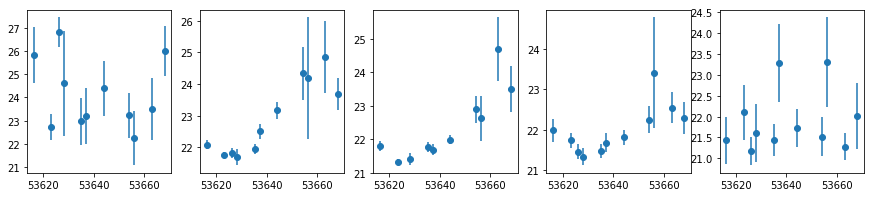

idx,FLAG,MJD,FILT,MAG,MERR,MSKYERR,MGALERR,FLUX,FLUXERR,SKYERR,GALERR,NPRE,TELE,RUN,STRIP,IDCCD
0,0,53616.24985,1,22.085,0.145,0.087,0.169,5.203,0.6924,0.4212,0.8154,13,sdss,5566,82N,5
1,32,53616.246533,2,21.798,0.147,0.043,0.117,6.872,0.9388,0.2726,0.7478,13,sdss,5566,82N,5
2,32,53616.247362,3,21.987,0.288,0.15,0.183,5.657,1.503,0.801,0.9785,14,sdss,5566,82N,5
3,32,53616.249021,4,21.429,0.555,0.231,0.375,8.922,5.06,2.203,3.579,15,sdss,5566,82N,5
4,128,53616.248192,0,25.821,1.219,0.289,1.929,-1.342,1.802,0.4523,3.017,4,sdss,5566,82N,5
5,0,53623.240007,1,21.753,0.096,0.012,0.058,7.077,0.6251,0.08052,0.376,13,sdss,5590,82N,5
6,0,53623.23669,2,21.312,0.085,0.028,0.039,10.78,0.8503,0.2793,0.3944,13,sdss,5590,82N,5
7,0,53623.23752,3,21.731,0.198,0.092,0.084,7.195,1.32,0.6178,0.5649,14,sdss,5590,82N,5
8,32,53623.239178,4,22.106,0.655,0.219,0.355,3.816,3.968,1.316,2.137,15,sdss,5590,82N,5
9,128,53623.238349,0,22.71,0.564,0.083,0.533,3.099,1.575,0.2477,1.596,4,sdss,5590,82N,5


In [5]:
test_id = 703

# Get fit published values
published_values = sdss.master_table[sdss.master_table['CID'] == test_id]
x0 = published_values['x0SALT2zspec'][0]
x1 = published_values['x1SALT2zspec'][0]
c = published_values['cSALT2zspec'][0]
chisq_norm = published_values['chi2SALT2zspec'][0] / published_values['ndofSALT2zspec'][0]
peak_mjd = published_values['MJDatPeakrmag'][0]

print('Published Values for CID {}:'.format(test_id))
print('x0: ', x0)
print('x1: ', x1)
print('c: ', c)
print('chisq: ', published_values['chi2SALT2zspec'][0])
print('ndof: ', published_values['ndofSALT2zspec'][0])
print('chisq_norm: ', chisq_norm)

# Get sdss photometry data and apply cuts described in Sako et al,
phot_data = sdss.get_data_for_id(test_id)
phot_data = phot_data[phot_data['FLAG'] < 1024]
phot_data = phot_data[phot_data['MJD'] < peak_mjd + 45]
phot_data = phot_data[phot_data['MJD'] > peak_mjd - 15]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    band_data = phot_data[phot_data['FILT'] == i]
    axes[i].scatter(band_data['MJD'], band_data['MAG'])
    axes[i].errorbar(band_data['MJD'], band_data['MAG'], yerr=band_data['MERR'], linestyle='')

plt.show()

phot_data.show_in_notebook(display_length=10)


## Create an SNCosmo input table

In [6]:
@np.vectorize
def sdss_mag_to_ab_flux(mag, band):
    """For a given sdss magnitude return the AB flux

    Args:
        mag (float): An SDSS asinh magnitude
        band  (str): The band of the magnitude doi_2010_<ugriz><123456>
        
    Return:
        The equivalent AB magnitude
    """

    if band[-2] == 'u':
        offset = -0.679

    elif band[-2] == 'g':
        offset = 0.0203

    elif band[-2] == 'r':
        offset = 0.0049

    elif band[-2] == 'i':
        offset = 0.0178

    elif band[-2] == 'z':
        offset = 0.0102

    else:
        ValueError('Unknown band {}'.format(band))

    return 3631 * 10 ** ((mag + offset) / -2.5)


def calc_err(sigma_sdss_mag, flux_ab):
    """Calculate the error of the AB magnitude equivilent for an SDSS asinh mag 
    
    Args:
        sigma_sdss_mag (float): Error in the SDSS magnitude
        flux_ab        (float): AB flux of the measurement
        
    Returns:
        The error in the equivalent AB flux
    """

    return sigma_sdss_mag * flux_ab * np.log(10) / 2.5


@np.vectorize
def band_name(filt, idccd):
    """Return the sncosmo band name given filter and CCD id
    
    Args:
        filt  (str): Filter name <ugriz>
        idccd (int): Column number 1 through 6
    
    Args:
        The name of the filter registered with sncosmo
    """

    return 'doi_2010_{}{}'.format('ugriz'[filt], idccd)


In [7]:
input_table = Table()
input_table.meta = phot_data.meta
input_table['time'] = phot_data['MJD']
input_table['band'] = band_name(phot_data['FILT'], phot_data['IDCCD'])
input_table['zp'] = np.full(len(phot_data), 2.5 * np.log10(3631))
input_table['flux'] = sdss_mag_to_ab_flux(phot_data['MAG'], input_table['band'])
input_table['fluxerr'] = calc_err(phot_data['MERR'], input_table['flux'])
input_table['zpsys'] = np.full(len(phot_data), 'ab')

if test_id in outliers:
    print('Wait you need to remove the outier data points!!!!!')

input_table.show_in_notebook(display_length=10)


idx,time,band,zp,flux,fluxerr,zpsys
0,53616.24985,doi_2010_g5,8.90006562228223,5.2228343158012325e-06,6.97509185447017e-07,ab
1,53616.246533,doi_2010_r5,8.90006562228223,6.900272611685336e-06,9.342417333717907e-07,ab
2,53616.247362,doi_2010_i5,8.90006562228223,5.729361810527322e-06,1.5197579248077604e-06,ab
3,53616.249021,doi_2010_z5,8.90006562228223,9.645977596657126e-06,4.930771897154626e-06,ab
4,53616.248192,doi_2010_u5,8.90006562228223,3.1858567850709654e-07,3.576890412221863e-07,ab
5,53623.240007,doi_2010_g5,8.90006562228223,7.090979811539386e-06,6.26979241296857e-07,ab
6,53623.23669,doi_2010_r5,8.90006562228223,1.079608384945627e-05,8.452026589720407e-07,ab
7,53623.23752,doi_2010_i5,8.90006562228223,7.252809138320514e-06,1.3226566481748423e-06,ab
8,53623.239178,doi_2010_z5,8.90006562228223,5.1706631849291195e-06,3.1193436962738572e-06,ab
9,53623.238349,doi_2010_u5,8.90006562228223,5.592760848648028e-06,2.905233430380244e-06,ab


## Run fit



Fitting for all terms except z:


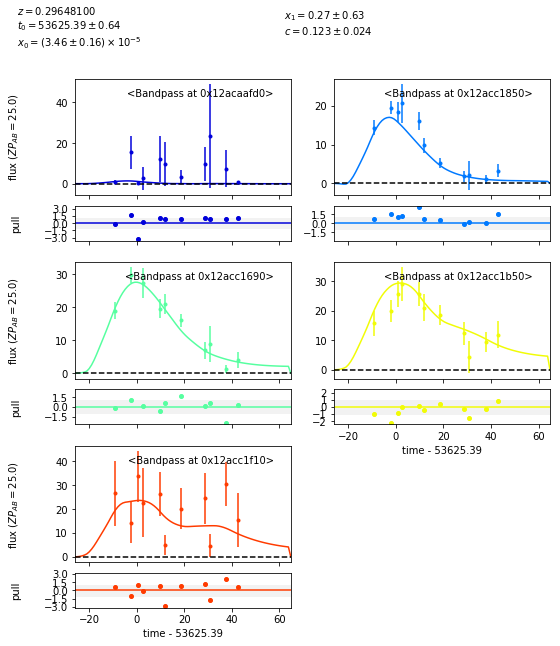

       errors: OrderedDict([('t0', 0.6449501434617559), ('x0', 1.6386706319971555e-06), ('x1', 0.6336002176388321), ('c', 0.02449596586014509)])
   parameters: array([2.96481000e-01, 5.36253929e+04, 3.45808770e-05, 2.70385143e-01,
       1.23167631e-01])
      success: True
    chi2_norm: 1.5834825073371905
    data_mask: array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])
         ndof: 50
   covariance: array([[ 4.15972033e-01,  2.60927860e-08, -9.63518962e-02,
         3.03515938e-03],
       [ 2.60927860e-08,  2.68524144e-12, -7.45777860e-07,
        -1.42223227e-08],
       [-9.63518962e-02, -7.45777860e-07,  4.0144923

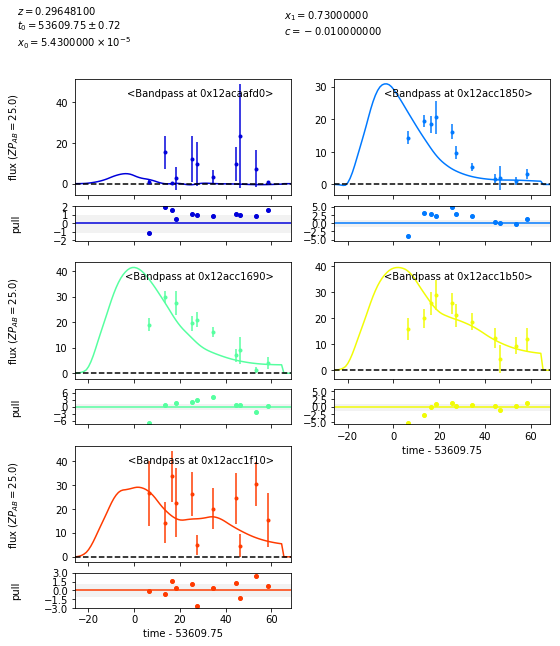

       errors: OrderedDict([('t0', 0.7182958730300015)])
   parameters: array([ 2.96481000e-01,  5.36097534e+04,  5.43000000e-05,  7.30000000e-01,
       -1.00000000e-02])
      success: True
    chi2_norm: 4.5724310749406465
    data_mask: array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])
         ndof: 53
   covariance: array([[0.51596699]])
 vparam_names: ['t0']
        chisq: 242.33884697185428
         nfit: 1
  param_names: ['z', 't0', 'x0', 'x1', 'c']
      message: 'Minimization exited successfully.'
        ncall: 23






In [8]:
print('\n\nFitting for all terms except z:')
source = sncosmo.get_source('salt2', version='2.0')
model = sncosmo.Model(source=source)
model.set(z=input_table.meta['redshift'])

result, fitted_model = sncosmo.fit_lc(input_table, model, ['t0', 'x0', 'x1', 'c'], bounds=None)
result['chi2_norm'] = (result.chisq / result.ndof)
sncosmo.plot_lc(input_table, model=fitted_model, errors=result.errors)
plt.show()
print(result)

print('\n\nFitting with fixed, published values:')
model.set(z=input_table.meta['redshift'], x0=x0, x1=x1, c=c)
result, fitted_model = sncosmo.fit_lc(input_table, model, ['t0'], bounds=None)
result['chi2_norm'] = (result.chisq / result.ndof)
sncosmo.plot_lc(input_table, model=fitted_model, errors=result.errors)
plt.show()
print(result)
print('\n\n\n')
